Road space evolution
====================
Reconstructs the road space allocation in a given year

In [1]:
import os
import pandas as pd
import geopandas as gpd
import shapely as shp
import snman
from snman.constants import *
import copy

PERIMETER = 'cambridge_extended'

# Set these paths according to your own setup
data_directory = os.path.join('C:',os.sep,'Users','lballo','polybox','Research','SNMan','SNMan Shared','data_v2')
inputs_path = os.path.join(data_directory, 'inputs')
process_path = os.path.join(data_directory, 'process', PERIMETER)

export_path = os.path.join(data_directory, 'roadspace_evolution', '_debug')

CRS_internal = 29119    # for Boston
#CRS_internal = 2056      # for Zurich

CRS_for_export = 4326

C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


Loading data
------------
Loads the prepared simplified street graph, as well as other datasets such as perimeters, rebuilding regions and measurement regions

In [2]:
print('Load street graph')
G = snman.io.load_street_graph(
    os.path.join(process_path, 'street_graph_edges.gpkg'),
    os.path.join(process_path, 'street_graph_nodes.gpkg'),
    crs=CRS_internal
)

Load street graph


In [3]:
lane_updates_cleaned_gpd = snman.io.import_geofile_to_gdf(
    os.path.join(export_path, 'lane_updates_cleaned.gpkg'),
    crs=CRS_internal
)

# keep only major cycling infra
# excluding shared streets and shared lane pavement markings
lane_updates_cleaned_gpd = lane_updates_cleaned_gpd.query('BIKE_FAC not in [2,6,7]')
lane_updates_cleaned_gpd

,from_year,to_year,add_lanes,BIKE_FAC,FacType,oneway,notes,error_in_official_data,geometry
0,2004,2023,NaN,1.0,NaN,NaN,NaN,NaN,"LINESTRING (328420.238 4692104.671, 328289.049..."
1,2004,2023,NaN,1.0,NaN,False,NaN,NaN,"LINESTRING (326954.968 4692351.025, 326636.968..."
2,2004,2023,NaN,1.0,NaN,True,NaN,False,"LINESTRING (326939.576 4692824.418, 327112.716..."
3,2004,2023,NaN,1.0,NaN,True,NaN,False,"LINESTRING (326412.518 4693555.170, 326109.523..."
4,2004,2023,NaN,1.0,NaN,True,NaN,NaN,"LINESTRING (325745.070 4693341.691, 325691.095..."
...,...,...,...,...,...,...,...,...,...
391,2019,2023,NaN,1.0,NaN,False,NaN,False,"LINESTRING (326220.094 4694367.600, 326398.344..."
392,2019,2023,NaN,1.0,NaN,False,NaN,False,"LINESTRING (326589.562 4693943.747, 326970.523..."
393,2008,2018,NaN,1.0,NaN,False,NaN,False,"LINESTRING (326970.115 4693497.947, 325812.450..."
394,2008,2023,NaN,1.0,NaN,False,NaN,False,"LINESTRING (325652.025 4695043.238, 325807.072..."


In [8]:
# MATCH THE MANUAL LANE UPDATES ONTO THE STREET GRAPH

for year, lane_key in lane_keys.items():
    
    print(year)
    
    for uvk, data in G.edges.items():
        data[lane_key] = copy.deepcopy(data[KEY_LANES_DESCRIPTION])
    
    lanes = gpd.GeoDataFrame(lane_updates_cleaned_gpd.query(f"from_year <= {year} <= to_year"))
    
    lanes_opposite = copy.deepcopy(lanes)
    lanes_opposite = lanes_opposite.query('oneway == False')
    lanes_opposite.geometry = lanes_opposite.geometry.apply(
        lambda geom: shp.ops.substring(geom, 1, 0, normalized=True)
    )
    
    lanes = gpd.GeoDataFrame(pd.concat([lanes, lanes_opposite], ignore_index=True), crs=lanes.crs)

    """
    snman.enrichment.match_lane_edits(G, lanes,
        remove_short_overlaps=True,
        remove_sidetrips=False,
        max_dist=30, max_dist_init=30, max_lattice_width=5,
        lanes_key=lane_key
    )
    """
    
    snman.enrichment.match_linestrings(
        G, lanes,
        [{'source_column': 'BIKE_FAC', 'target_column': '_factype_' + lane_key, 'agg': 'list'}],
        remove_short_overlaps=True,
        remove_sidetrips=False,
        max_dist=400, max_dist_init=100, max_lattice_width=5,
        _save_map=(os.path.join(export_path, '_matching_edges.gpkg'), os.path.join(export_path, '_matching_nodes.gpkg'))
    )
    

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [9]:
# CALCULATE CHANGE ON EDGES
if 1:
    for uvk, data in G.edges.items():
        
        previous_lane_key = None
        for year, lane_key in lane_keys.items():
            
            if previous_lane_key is None:
                data['_bike_fac_change_' + lane_key] = 0
                
            else:
            
                bike_facilities_previous_year = set(
                    data['_factype_' + previous_lane_key + '_forward'] + 
                    data['_factype_' + previous_lane_key + '_backward']
                )
                
                bike_facilities_this_year = set(
                    data['_factype_' + lane_key + '_forward'] + 
                    data['_factype_' + lane_key + '_backward']
                )
                
                if bike_facilities_this_year != bike_facilities_previous_year:
                    data['_bike_fac_change_' + lane_key] = 1
                else:
                    data['_bike_fac_change_' + lane_key] = 0
                
            previous_lane_key = lane_key
            
    edges_df = snman.oxc.graph_to_gdfs(G, nodes=False).assign(x=1)
    timeline_df = pd.DataFrame({'year': lane_keys.keys(), 'lanes_key': lane_keys.values()}).assign(x=1)
    
    changes_df = pd.merge(edges_df, timeline_df, on='x')
    
    changes_df['change'] = changes_df.apply(lambda row: row['_bike_fac_change_steps_' + str(row['year'])], axis=1)
    
    changes_df = changes_df.query('change==1')
    
    changes_df = gpd.GeoDataFrame(changes_df[['osmid', 'year', 'lanes_key', 'change', 'geometry']])
    
    snman.io.export_gdf(changes_df, os.path.join(export_path, 'edge_changes.gpkg'))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[4]
[4]
[]
[]
[4]
[4]
[4]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[4]
[4]
[]
[]
[4]
[4]
[4]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1]
[1]
[1]
[1]
[]
[]
[]
[]
[1]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1]
[1]
[]
[]
[]
[]
[]
[]
[1]
[1]
[1]
[1]
[]
[]
[4]
[4]
[]
[]
[]
[]
[4]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1]
[1]
[8]
[8]
[1]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[4]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1]
[]
[]
[4]
[4]
[]
[]
[]
[]
[]
[]
[1]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [13]:
if 0:
    def cycling_lanes_length(lanes_key):
        L = snman.lane_graph.create_lane_graph(H, lanes_key)
        return sum(
            [
                e['length']
                for uvk, e
                in L.edges.items()
                if e['lanetype'] == LANETYPE_CYCLING_LANE and e['width'] > 0
            ]
        ) / 1000
    
    def car_lanes_length(lanes_key):
        L = snman.lane_graph.create_lane_graph(H, lanes_key)
        return sum(
            [
                e['length']
                for uvk, e
                in L.edges.items()
                if e['lanetype'] == LANETYPE_MOTORIZED and e['width'] > 0
            ]
        ) / 1000

In [14]:
# GENERATE METRICS
if 0:
    import pandas as pd
    import copy
    
    timeline_df = pd.DataFrame()
    
    for name, data in measurement_regions_gdf.iterrows():
        
        polygon = data.geometry
        H = snman.oxc.truncate.truncate_graph_polygon(G, polygon, quadrat_width=100, retain_all=True)
        
        timeline_df_one_region = pd.DataFrame({'year': lane_keys.keys(), 'lanes_key': lane_keys.values()})
        timeline_df_one_region['measurement_region_name'] = name
        timeline_df_one_region['cycling_lanes_length'] = timeline_df_one_region['lanes_key'].apply(cycling_lanes_length)
        timeline_df_one_region['change_metric'] = timeline_df_one_region['cycling_lanes_length'].diff().fillna(0)
        
        #print(timeline_df_one_region)
        
        timeline_df = pd.concat([timeline_df, timeline_df_one_region], axis=0, ignore_index=True)
        
        timeline_gdf = gpd.GeoDataFrame(
            pd.merge(timeline_df, measurement_regions_gdf, left_on='measurement_region_name', right_index=True, how='left')
        )  
        
        snman.io.export_gdf(timeline_gdf, os.path.join(export_path, 'timeline.gpkg'))

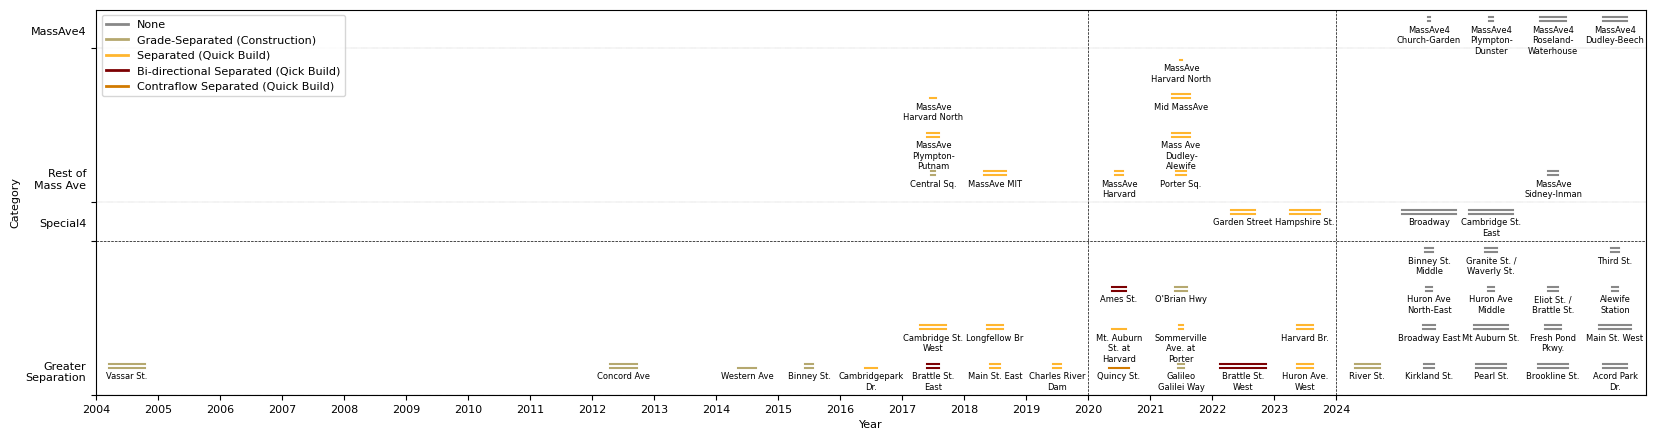

In [17]:
pd.DataFrame(projects_gdf.groupby('bike_facility').agg({'bike_facility_color': 'first', 'bike_facility_name': 'first'}).reset_index())

,bike_facility,bike_facility_color,bike_facility_name
0,0.0,#888888,None
1,4.0,#b5a86f,Grade-Separated (Construction)
2,8.0,#ffb62f,Separated (Quick Build)
3,83.0,#7c0002,Bi-directional Separated (Qick Build)
4,84.0,#d17a00,Contraflow Separated (Quick Build)


Export
------
Saves the resulting datasets to the disk. Use the *snman_detailed.qgz* file to view them in QGIS.

In [18]:
if 1:
    print('Export network without lanes')
    snman.io.export_street_graph(
        G,
        os.path.join(export_path, 'street_graph_edges.gpkg'),
        os.path.join(export_path, 'street_graph_nodes.gpkg'),
        crs=CRS_for_export,
        lane_keys=[KEY_LANES_DESCRIPTION, KEY_GIVEN_LANES_DESCRIPTION, KEY_LANES_DESCRIPTION_AFTER] + list(lane_keys.values())
    )

if 0:
    print('Export lane geometries')
    SCALING = 1
    snman.io.export_street_graph_with_lanes(
        G,
        list(lane_keys.values()),
        os.path.join(export_path, 'lane_geometries.shp'),
        scaling=SCALING,
        crs=CRS_for_export
    )

Export network without lanes
